kroki:
1. wybor zmiennych wejsciowych i wyjsciowych
2. wybor dziedziny - nosniki zbiorow rozmytych
3. zmienne lingwistyczne (malo, srednio, duzo) dla wejscia+wyjscia, najlepiej 3-7
4. opisanie ilosciowe zmiennych lingwistycznych - funkcje przynaleznosci, x - dziedzina, y - [0,1], dla kazdego przedzialu sa raczej 2 funkcje
5. baza regul: jezeli wej1 oraz wej2 wtedy wyj, mozna zobrazowac tabela

dzialanie wnioskowania (mamdani - minmax):
1. sprawdzenie jak wartosci wejsciowe maja sie do funkcji przynaleznosci 
2. w tabelce znajduje te przedzialy i dla nich mam reguly
3. pod wartosci lingwistyczne podstawiam funkcje przynaleznosci, licze min wartosci dla kazdej reguly
4. max jest suma - takim obszarem, robie defuzzyfikacje zazwyczaj metoda srodka ciezkosci, ktory jest rozwiazaniem

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time
import skfuzzy as fuzz
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
def get_face_shape():
    mp_face_mesh = mp.solutions.face_mesh
    mp_drawing = mp.solutions.drawing_utils
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)
    shape_counter = Counter()

    #funkcja do odleglosci na twarzy
    def euclidean(p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))

    #kamerka
    cap = cv2.VideoCapture(0)
    start_time = time.time()
    shape = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time > 5:
            break

        h, w = frame.shape[:2]
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb)

        if results.multi_face_landmarks:
            for landmarks in results.multi_face_landmarks:
                lm = [(int(pt.x * w), int(pt.y * h)) for pt in landmarks.landmark]

                #siatka 
                mp_drawing.draw_landmarks(
                    frame, landmarks, mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1)
                )

                #punkty na twarze
                cheek_left = lm[234]
                cheek_right = lm[454]
                chin = lm[152]
                forehead = lm[10]
                forehead_left = lm[21]
                forehead_right = lm[251]
                under_ear = lm[323]
                jawline_left = lm[58]
                jawline_right = lm[288]

                #pomiary twarzy
                cheeks_width = euclidean(cheek_left, cheek_right)
                face_length = euclidean(chin, forehead) * 1.2
                forehead_width = euclidean(forehead_left, forehead_right)
                jawline_length = euclidean(chin, under_ear)
                jawline_width = euclidean(jawline_left, jawline_right)

                #wybranie ksztaltu
                if face_length > cheeks_width and forehead_width > jawline_width:
                    shape_counter['oval'] += 1
                if face_length > cheeks_width and jawline_width / forehead_width > 0.9 and jawline_width/cheeks_width > 0.9:
                    shape_counter['oblong'] += 1
                if cheeks_width / face_length > 0.9 and forehead_width < cheeks_width and jawline_width < cheeks_width:
                    shape_counter['round'] += 1
                if cheeks_width / face_length > 0.8 and jawline_width / forehead_width > 0.85:
                    shape_counter['square'] += 1
                if jawline_width / cheeks_width > 0.9 and cheeks_width > forehead_width:
                    shape_counter['triangle'] += 1
                if jawline_width / cheeks_width < 0.7 and 0.9 < forehead_width / cheeks_width < 1.1:
                    shape_counter['heart'] += 1
                if jawline_width < cheeks_width and forehead_width < cheeks_width and face_length / cheeks_width > 0.9:
                    shape_counter['diamond'] += 1

        #twarz z siatka
        cv2.imshow("Face Shape Detector (auto-closes in 5s)", frame)
        cv2.waitKey(1)

    cap.release()
    cv2.destroyAllWindows()

    for shape, count in shape_counter.items():
        print(f"{shape}: {count}")
        
    return shape_counter

In [3]:
sorted_shape = get_face_shape().most_common()
max_count = sorted_shape[0][1]
shape = [shape for shape, count in sorted_shape if count >=  0.5 * max_count]
shape

I0000 00:00:1747474794.393291 5439476 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747474794.395547 5439638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747474794.401033 5439638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
2025-05-17 11:39:54.481 python[8443:5439476] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
W0000 00:00:1747474795.707038 5439644 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


oval: 146
oblong: 1
triangle: 1
diamond: 146


['oval', 'diamond']

In [4]:
def face_triangle(x):
    if x <= 1.5:
        return 1
    elif 1.5 < x < 2.5:
        return 2.5 - x
    else:
        return 0

def face_heart(x):
    if x <= 1.5 or x >= 4.5:
        return 0
    elif 1.5 < x < 2.5:
        return x - 1.5
    elif 2.5 <= x <= 3.5:
        return 1
    else:
        return 4.5 - x

def face_diamond(x):
    if x <= 3.5 or x >= 6.5:
        return 0
    elif 3.5 < x < 4.5:
        return x - 3.5
    elif 4.5 <= x <= 5.5:
        return 1
    else:
        return 6.5 - x

def face_round(x):
    if x <= 5.5 or x >= 8.5:
        return 0
    elif 5.5 < x < 6.5:
        return x - 5.5
    elif 6.5 <= x <= 7.5:
        return 1
    else:
        return 8.5 - x

def face_oblong(x):
    if x <= 6.5 or x >= 8.5:
        return 0
    elif 6.5 < x <= 7.5:
        return x - 6.5
    else:
        return 8.5 - x

def face_oval(x):
    if x <= 7.5 or x >= 9.5:
        return 0
    elif 7.5 < x < 8.5:
        return x - 7.5
    elif 8.5 <= x <= 9.0:
        return 1
    else:
        return 9.5 - x

def face_square(x):
    if x <= 9.0:
        return 0
    elif 9.0 < x < 9.5:
        return (x - 9.0) * 2
    else:
        return 1

# Gender
def gender_female(x):
    if x <= 2:
        return 1
    elif 2 < x < 4:
        return (4 - x) / 2
    else:
        return 0

def gender_unisex(x):
    if x <= 3 or x >= 7:
        return 0
    elif 3 < x <= 5:
        return (x - 3) / 2
    else:
        return (7 - x) / 2

def gender_male(x):
    if x <= 6:
        return 0
    elif 6 < x < 8:
        return (x - 6) / 2
    else:
        return 1

# Frames
def frames_rectangle(x):
    if x <= 1:
        return 1
    elif 1 < x < 2:
        return 2 - x
    else:
        return 0

def frames_square(x):
    if x <= 1 or x >= 4:
        return 0
    elif 1 < x < 2:
        return x - 1
    elif 2 <= x <= 3:
        return 1
    else:
        return 4 - x

def frames_wayfarer(x):
    if x <= 3 or x >= 6:
        return 0
    elif 3 < x < 4:
        return x - 3
    elif 4 <= x <= 5:
        return 1
    else:
        return 6 - x

def frames_browline(x):
    if x <= 5 or x >= 8:
        return 0
    elif 5 < x < 6:
        return x - 5
    elif 6 <= x <= 7:
        return 1
    else:
        return 8 - x

def frames_oval(x):
    if x <= 7 or x >= 9:
        return 0
    elif 7 < x < 8:
        return x - 7
    elif 8 <= x <= 8.5:
        return 1
    else:
        return 9 - x

def frames_aviators(x):
    if x <= 8.5 or x >= 9.4:
        return 0
    elif 8.5 < x < 9:
        return (x - 8.5) * 2
    elif 9 <= x <= 9.2:
        return 1
    else:
        return (9.4 - x) * 5

def frames_round(x):
    if x <= 9.2 or x >= 9.8:
        return 0
    elif 9.2 < x < 9.4:
        return (x - 9.2) * 5
    elif 9.4 <= x <= 9.6:
        return 1
    else:
        return (9.8 - x) * 5

def frames_geometric(x):
    if x <= 9.6 or x >= 10:
        return 0
    elif 9.6 < x < 9.8:
        return (x - 9.6) * 5
    elif 9.8 <= x <= 9.9:
        return 1
    else:
        return (10 - x) * 10

def frames_wrap(x):
    if x <= 9.9:
        return 0
    elif 9.9 < x <= 10:
        return (x - 9.9) * 10
    else:
        return 1


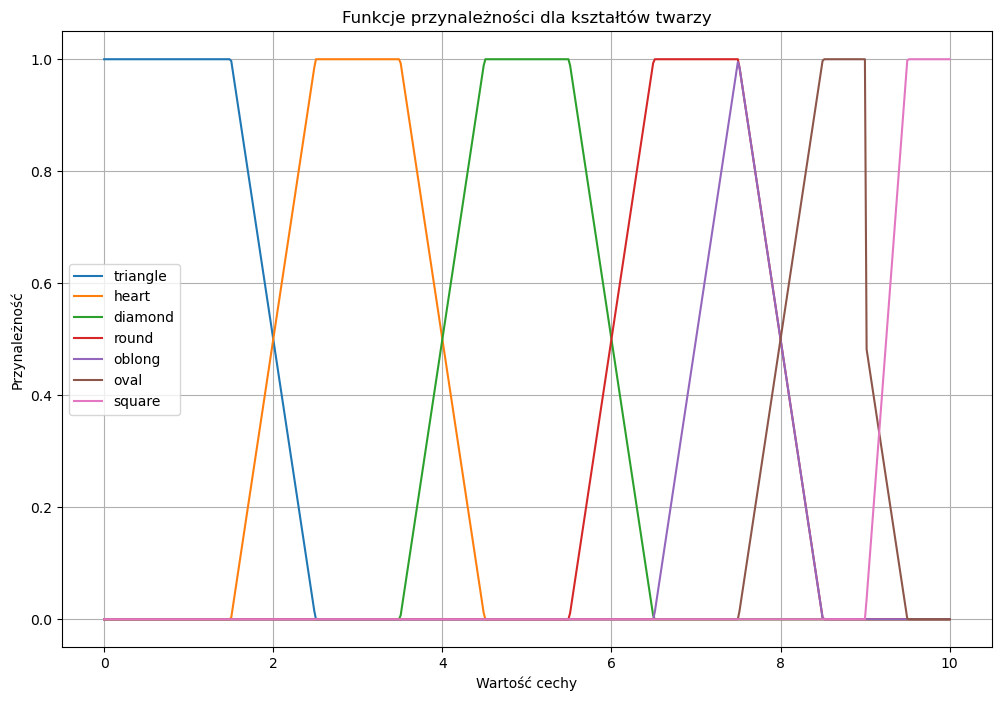

In [5]:
x = np.linspace(0, 10, 500)
plt.figure(figsize=(12, 8))

plt.plot(x, [face_triangle(val) for val in x], label="triangle")
plt.plot(x, [face_heart(val) for val in x], label="heart")
plt.plot(x, [face_diamond(val) for val in x], label="diamond")
plt.plot(x, [face_round(val) for val in x], label="round")
plt.plot(x, [face_oblong(val) for val in x], label="oblong")
plt.plot(x, [face_oval(val) for val in x], label="oval")
plt.plot(x, [face_square(val) for val in x], label="square")

plt.title("Funkcje przynależności dla kształtów twarzy")
plt.xlabel("Wartość cechy")
plt.ylabel("Przynależność")
plt.grid(True)
plt.legend()
plt.show()


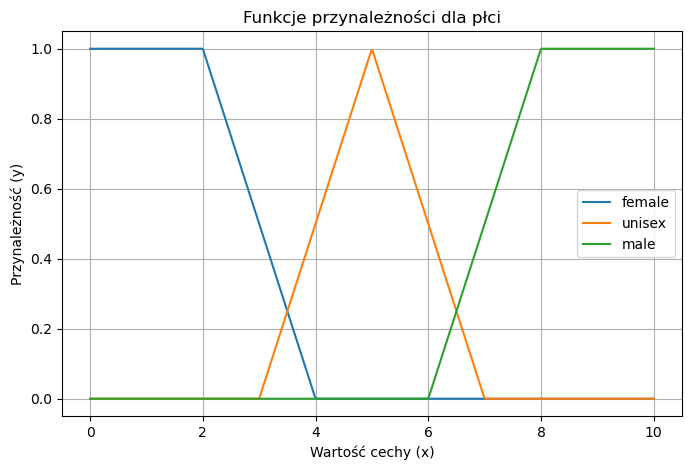

In [6]:
x = np.linspace(0, 10, 500)
plt.figure(figsize=(8, 5))

plt.plot(x, [gender_female(val) for val in x], label="female")
plt.plot(x, [gender_unisex(val) for val in x], label="unisex")
plt.plot(x, [gender_male(val) for val in x], label="male")

plt.title("Funkcje przynależności dla płci")
plt.xlabel("Wartość cechy (x)")
plt.ylabel("Przynależność (y)")
plt.grid(True)
plt.legend()
plt.show()


In [7]:
rules = [
    # Triangle + Female
    {"weight": 1.0, "face": "triangle", "gender": "female", "frames": "rectangle"},
    {"weight": 0.9, "face": "triangle", "gender": "female", "frames": "oval"},
    {"weight": 0.8, "face": "triangle", "gender": "female", "frames": "browline"},
    {"weight": 0.7, "face": "triangle", "gender": "female", "frames": "aviators"},
    {"weight": 0.6, "face": "triangle", "gender": "female", "frames": "geometric"},
    {"weight": 0.5, "face": "triangle", "gender": "female", "frames": "wrap"},
    
    # Triangle + Unisex
    {"weight": 1.0, "face": "triangle", "gender": "unisex", "frames": "rectangle"},
    {"weight": 0.9, "face": "triangle", "gender": "unisex", "frames": "browline"},
    {"weight": 0.8, "face": "triangle", "gender": "unisex", "frames": "aviators"},
    {"weight": 0.7, "face": "triangle", "gender": "unisex", "frames": "geometric"},
    {"weight": 0.6, "face": "triangle", "gender": "unisex", "frames": "wrap"},

    # Triangle + Male
    {"weight": 1.0, "face": "triangle", "gender": "male", "frames": "rectangle"},
    {"weight": 0.9, "face": "triangle", "gender": "male", "frames": "browline"},
    {"weight": 0.8, "face": "triangle", "gender": "male", "frames": "aviators"},
    {"weight": 0.7, "face": "triangle", "gender": "male", "frames": "geometric"},
    {"weight": 0.6, "face": "triangle", "gender": "male", "frames": "wrap"},

    # Heart + Female
    {"weight": 1.0, "face": "heart", "gender": "female", "frames": "rectangle"},
    {"weight": 0.9, "face": "heart", "gender": "female", "frames": "aviators"},
    {"weight": 0.8, "face": "heart", "gender": "female", "frames": "geometric"},
    {"weight": 0.7, "face": "heart", "gender": "female", "frames": "wrap"},

    # Heart + Unisex
    {"weight": 1.0, "face": "heart", "gender": "unisex", "frames": "rectangle"},
    {"weight": 0.9, "face": "heart", "gender": "unisex", "frames": "aviators"},
    {"weight": 0.8, "face": "heart", "gender": "unisex", "frames": "geometric"},
    {"weight": 0.7, "face": "heart", "gender": "unisex", "frames": "wrap"},

    # Heart + Male
    {"weight": 1.0, "face": "heart", "gender": "male", "frames": "rectangle"},
    {"weight": 0.9, "face": "heart", "gender": "male", "frames": "aviators"},
    {"weight": 0.8, "face": "heart", "gender": "male", "frames": "geometric"},
    {"weight": 0.7, "face": "heart", "gender": "male", "frames": "wrap"},

    # Diamond + Female
    {"weight": 1.0, "face": "diamond", "gender": "female", "frames": "oval"},
    {"weight": 0.9, "face": "diamond", "gender": "female", "frames": "aviators"},
    {"weight": 0.8, "face": "diamond", "gender": "female", "frames": "round"},
    {"weight": 0.7, "face": "diamond", "gender": "female", "frames": "wrap"},

    # Diamond + Unisex
    {"weight": 1.0, "face": "diamond", "gender": "unisex", "frames": "oval"},
    {"weight": 0.9, "face": "diamond", "gender": "unisex", "frames": "aviators"},
    {"weight": 0.8, "face": "diamond", "gender": "unisex", "frames": "round"},
    {"weight": 0.7, "face": "diamond", "gender": "unisex", "frames": "wrap"},

    # Diamond + Male
    {"weight": 1.0, "face": "diamond", "gender": "male", "frames": "oval"},
    {"weight": 0.9, "face": "diamond", "gender": "male", "frames": "aviators"},
    {"weight": 0.8, "face": "diamond", "gender": "male", "frames": "round"},
    {"weight": 0.7, "face": "diamond", "gender": "male", "frames": "wrap"},

    # Round + Female
    {"weight": 1.0, "face": "round", "gender": "female", "frames": "rectangle"},
    {"weight": 0.9, "face": "round", "gender": "female", "frames": "square"},
    {"weight": 0.8, "face": "round", "gender": "female", "frames": "aviators"},
    {"weight": 0.7, "face": "round", "gender": "female", "frames": "wrap"},

    # Round + Unisex
    {"weight": 1.0, "face": "round", "gender": "unisex", "frames": "rectangle"},
    {"weight": 0.9, "face": "round", "gender": "unisex", "frames": "square"},
    {"weight": 0.8, "face": "round", "gender": "unisex", "frames": "aviators"},
    {"weight": 0.7, "face": "round", "gender": "unisex", "frames": "wrap"},

    # Round + Male
    {"weight": 1.0, "face": "round", "gender": "male", "frames": "rectangle"},
    {"weight": 0.9, "face": "round", "gender": "male", "frames": "square"},
    {"weight": 0.8, "face": "round", "gender": "male", "frames": "aviators"},
    {"weight": 0.7, "face": "round", "gender": "male", "frames": "wrap"},

    # Oblong + Female
    {"weight": 1.0, "face": "oblong", "gender": "female", "frames": "rectangle"},
    {"weight": 0.9, "face": "oblong", "gender": "female", "frames": "square"},
    {"weight": 0.8, "face": "oblong", "gender": "female", "frames": "aviators"},
    {"weight": 0.7, "face": "oblong", "gender": "female", "frames": "wrap"},

    # Oblong + Unisex
    {"weight": 1.0, "face": "oblong", "gender": "unisex", "frames": "rectangle"},
    {"weight": 0.9, "face": "oblong", "gender": "unisex", "frames": "square"},
    {"weight": 0.8, "face": "oblong", "gender": "unisex", "frames": "aviators"},
    {"weight": 0.7, "face": "oblong", "gender": "unisex", "frames": "wrap"},

    # Oblong + Male
    {"weight": 1.0, "face": "oblong", "gender": "male", "frames": "rectangle"},
    {"weight": 0.9, "face": "oblong", "gender": "male", "frames": "square"},
    {"weight": 0.8, "face": "oblong", "gender": "male", "frames": "aviators"},
    {"weight": 0.7, "face": "oblong", "gender": "male", "frames": "wrap"},

    # Oval + Female
    {"weight": 1.0, "face": "oval", "gender": "female", "frames": "rectangle"},
    {"weight": 0.9, "face": "oval", "gender": "female", "frames": "square"},
    {"weight": 0.8, "face": "oval", "gender": "female", "frames": "aviators"},
    {"weight": 0.7, "face": "oval", "gender": "female", "frames": "wrap"},

    # Oval + Unisex
    {"weight": 1.0, "face": "oval", "gender": "unisex", "frames": "rectangle"},
    {"weight": 0.9, "face": "oval", "gender": "unisex", "frames": "square"},
    {"weight": 0.8, "face": "oval", "gender": "unisex", "frames": "aviators"},
    {"weight": 0.7, "face": "oval", "gender": "unisex", "frames": "wrap"},

    # Oval + Male
    {"weight": 1.0, "face": "oval", "gender": "male", "frames": "rectangle"},
    {"weight": 0.9, "face": "oval", "gender": "male", "frames": "square"},
    {"weight": 0.8, "face": "oval", "gender": "male", "frames": "aviators"},
    {"weight": 0.7, "face": "oval", "gender": "male", "frames": "wrap"},

    # Square + Female
    {"weight": 1.0, "face": "square", "gender": "female", "frames": "rectangle"},
    {"weight": 0.9, "face": "square", "gender": "female", "frames": "square"},
    {"weight": 0.8, "face": "square", "gender": "female", "frames": "aviators"},
    {"weight": 0.7, "face": "square", "gender": "female", "frames": "wrap"},

    # Square + Unisex
    {"weight": 1.0, "face": "square", "gender": "unisex", "frames": "rectangle"},
    {"weight": 0.9, "face": "square", "gender": "unisex", "frames": "square"},
    {"weight": 0.8, "face": "square", "gender": "unisex", "frames": "aviators"},
    {"weight": 0.7, "face": "square", "gender": "unisex", "frames": "wrap"},

    # Square + Male
    {"weight": 1.0, "face": "square", "gender": "male", "frames": "rectangle"},
    {"weight": 0.9, "face": "square", "gender": "male", "frames": "square"},
    {"weight": 0.8, "face": "square", "gender": "male", "frames": "aviators"},
    {"weight": 0.7, "face": "square", "gender": "male", "frames": "wrap"},
]


In [8]:
# function dictionary
face_functions = {
    "triangle": face_triangle,
    "heart": face_heart,
    "diamond": face_diamond,
    "round": face_round,
    "oblong": face_oblong,
    "oval": face_oval,
    "square": face_square,
}

gender_functions = {
    "female": gender_female,
    "unisex": gender_unisex,
    "male": gender_male,
}

frames_functions = {
    "rectangle": frames_rectangle,
    "square": frames_square,
    "wayfarer": frames_wayfarer,
    "browline": frames_browline,
    "oval": frames_oval,
    "aviators": frames_aviators,
    "round": frames_round,
    "geometric": frames_geometric,
    "wrap": frames_wrap,
}

# face shape to numeric
face_shape_mapping = {
    "triangle": 1.0,
    "heart": 3.0,
    "diamond": 5.0,
    "round": 7.0,
    "oblong": 7.5,
    "oval": 8.7,
    "square": 9.7
}

# gender to numeric
gender_mapping = {
    "female": 1.0,
    "unisex": 5.0,
    "male": 9.0
}

In [9]:
def multi_face_fuzzy_inference(face_shapes, gender_pref, shape_weights=None):
    # if none then equal
    if shape_weights is None:
        total_faces = len(face_shapes)
        shape_weights = {shape: 1.0/total_faces for shape in face_shapes}
    
    x_gender = gender_mapping.get(gender_pref, 5.0) #unisex
    gender_degrees = {name: func(x_gender) for name, func in gender_functions.items()}
    
    combined_frame_scores = {}
    
    for face_shape in face_shapes:
        x_face = face_shape_mapping.get(face_shape, 8.7)  #oval
        face_degrees = {name: func(x_face) for name, func in face_functions.items()}
        
        face_results = []
        for rule in rules:
            if rule["face"] != face_shape:
                continue
                
            f_degree = face_degrees.get(rule["face"], 0)
            g_degree = gender_degrees.get(rule["gender"], 0)
            
            activation = min(f_degree, g_degree)
            weighted_activation = activation * rule["weight"] * shape_weights[face_shape]
            
            if weighted_activation > 0:
                face_results.append((rule["frames"], weighted_activation))
        
        for frame, score in face_results:
            combined_frame_scores[frame] = max(combined_frame_scores.get(frame, 0), score)
    
    sorted_frames = sorted(combined_frame_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_frames


Multiple face shapes detected. How would you like to handle them?
1. Use equal weights for all detected shapes
2. Prioritize the most dominant shape
3. Enter custom weights

Detected face shapes: oval, diamond
Gender preference: female

Weights applied to each face shape:
oval: 0.70
diamond: 0.30

Recommended eyeglass frames:
rectangle: 0.70
square: 0.63
aviators: 0.56
wrap: 0.49
oval: 0.30
round: 0.24


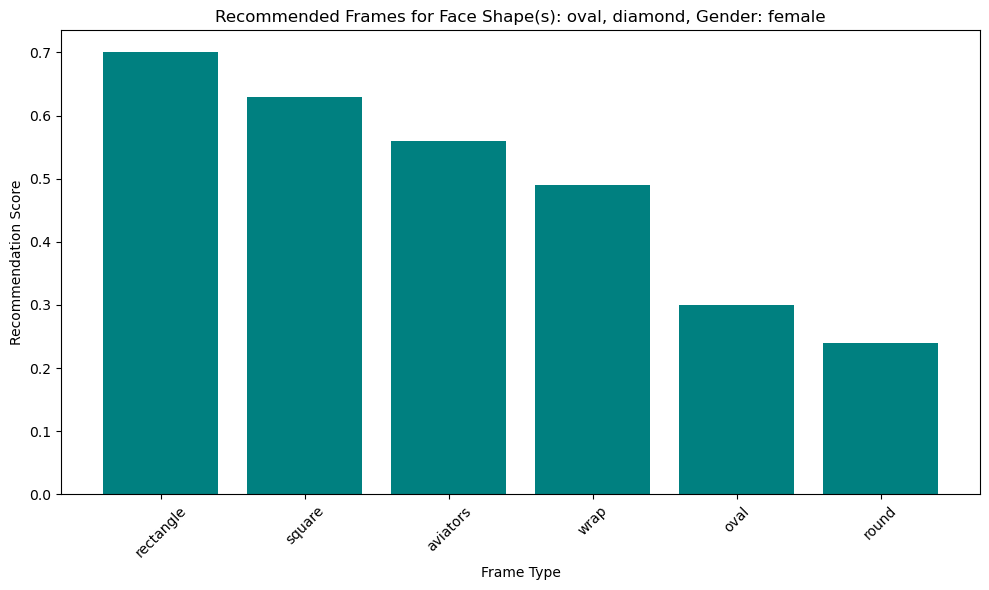

In [10]:
def recommend_glasses(shape):
    face_shapes = shape
    
    gender = input("\nEnter preferred gender style (male/female/unisex): ").strip().lower()
    if gender not in ["male", "female", "unisex"]:
        print('Invalid value - defaulting to unisex')
        gender = "unisex"
    
    # weights for multiple face shapes
    if len(face_shapes) > 1:
        print("\nMultiple face shapes detected. How would you like to handle them?")
        print("1. Use equal weights for all detected shapes")
        print("2. Prioritize the most dominant shape")
        print("3. Enter custom weights")
        
        choice = input("Enter your choice (1-3): ").strip()
        
        shape_weights = {}
        
        if choice == "1":
            total = len(face_shapes)
            shape_weights = {shape: 1.0/total for shape in face_shapes}
        elif choice == "2":
            dominant_weight = 0.7
            other_weight = (1.0 - dominant_weight) / (len(face_shapes) - 1) if len(face_shapes) > 1 else 0
            
            for i, shape in enumerate(face_shapes):
                shape_weights[shape] = dominant_weight if i == 0 else other_weight
        elif choice == "3":
            print("\nEnter weights (0-10) for each face shape:")
            total_weight = 0
            
            for shape in face_shapes:
                weight = float(input(f"{shape}: "))
                shape_weights[shape] = weight
                total_weight += weight
            
            for shape in shape_weights:
                shape_weights[shape] /= total_weight
        else:
            total = len(face_shapes)
            shape_weights = {shape: 1.0/total for shape in face_shapes}
    else:
        shape_weights = {face_shapes[0]: 1.0}
    
    results = multi_face_fuzzy_inference(face_shapes, gender, shape_weights)
    
    print(f"\nDetected face shapes: {', '.join(face_shapes)}")
    print(f"Gender preference: {gender}")
    
    print("\nWeights applied to each face shape:")
    for shape, weight in shape_weights.items():
        print(f"{shape}: {weight:.2f}")
    
    print("\nRecommended eyeglass frames:")
    for frame, score in results:
        print(f"{frame}: {score:.2f}")
    
    frames = [frame for frame, _ in results]
    scores = [score for _, score in results]
    
    plt.figure(figsize=(10, 6))
    plt.bar(frames, scores, color='teal')
    plt.xlabel('Frame Type')
    plt.ylabel('Recommendation Score')
    plt.title(f'Recommended Frames for Face Shape(s): {", ".join(face_shapes)}, Gender: {gender}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

recommend_glasses(shape)